# Logistic Regression Sentiment analisys

Datasets are taken from:
* nltk.download('twitter_samples')
* nltk.download('stopwords')

In [1]:
import sys
sys.path.insert(0, '..')

In [4]:
import numpy as np
from os import path
from src.data.make_datasets import preprocess_data
from src.utils import build_freqs
from src.features.make_features import extract_features
from src.model.train_model import gradientDescent
from src.model.evaluate_model import evaluate
from src.utils import process_tweet

## Preprocess the data

* Train test split
* Create arrays of positive and negative labels

preprocess data is running
========= About the data: ============
The type of all_positive_tweets is:  <class 'list'>
The type of a tweet entry is:  <class 'str'> 

Number of positive tweets:  5000
Number of negative tweets:  5000

Example tweets:
Positive: @plasmov Love your author pic on the MWF programme! You're going to rock it :)
Negative: I've been such a shit bestfriend.:(

Size of train set, its type:  8000 <class 'list'>
Size of test set, its type:  2000 <class 'numpy.ndarray'>

Type of labels = <class 'numpy.ndarray'>
Shape of train labels =  (1, 8000)
Shape of test labels =  (1, 2000)
Positive label: 1
Negative label: 0

This is an example of a tweet: 
 #FollowFriday @wncer1 @Defense_gouv for being top influencers in my community this week :)
========= About the data END =========


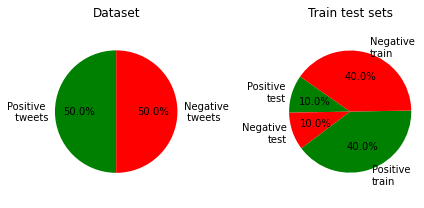

In [5]:
#process data
train_x, train_y, test_x, test_y = preprocess_data(train_size=0.8, test_size=0.2, valid_size=0.0, printInfo=True)

## Preprocess raw text for Sentiment analysis

* Tokenizing the string  (splitting the strings into individual words without blanks or tabs)
* Lowercasing (converting each word in the string to lower case)
* Removing stop words and punctuation
* Stemming (stop words (as well as punctuation) are words that don't add significant meaning to the text)

```python
def process_tweet(tweet):
    """
    Process tweet function.

    Arguments:
        tweet -- a string containing a tweet
    Returns:
        tweets_clean -- a list of words containing the processed tweet.

    """

    # two levels up: path.abspath(path.join(__file__, "../.."))
    filePath = path.abspath(__file__ + "/../../") + '/nltk_data'
    nltk.data.path.append(filePath)

    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)

    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)

    # remove hyperlinks    
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)

    # remove hashtags by only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)

    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweet_clean = []
    for word in tweet_tokens:
        if (word not in stopwords.words('english') and     # remove stopwords in English
                word not in string.punctuation):           # remove punctuation
            stem_word = PorterStemmer().stem(word)  # stemming word
            tweet_clean.append(stem_word)

    return tweet_clean
```

In [6]:
print('tweet:\n', train_x[10])
print('\n Processed tweet: \n', process_tweet(train_x[10]))

tweet:
 #FollowFriday @wncer1 @Defense_gouv for being top influencers in my community this week :)

 Processed tweet: 
 ['followfriday', 'top', 'influenc', 'commun', 'week', ':)']


## Create the frequency dictionary 

* Create a dictionary mapping each (PROCESSED word, sentiment) pair to its frequency, i.e., how frequent a certain (PROCESSED word, sentiment) pair appears in the dictionary.

```python
def build_freqs(tweets, labels):
    """
        Creates a dictionary mapping each (PROCESSED word, sentiment) pair to its 
        frequency, i.e.,how frequent a certain (PROCESSED word, sentiment) pair 
        appears in the dictionary.

    Arguments:
        tweets -- a list of tweets
        ys -- an m x 1 array with the sentiment label of each tweet (either 0 or 1)
    Returns:
        freqs -- a dictionary mapping each (word, sentiment) pair to its frequency
    """

    print("build_freqs is running")
    # Convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    # Also note that this is just a NOP if ys is already a list.
    labels_list = np.squeeze(labels).tolist()

    # Start with an empty dictionary and populate it by looping over all tweets
    # and over all processed words in each tweet.
    freqs = {}
    for y, tweet in zip(labels_list, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs
```

In [7]:
#build freqs dictionary
freqs = build_freqs(train_x, train_y)

build_freqs is running


## Training the Model

* Stack the features for all training examples into a matrix X.
* Call gradientDescent (with logistic regression)

```python
def gradientDescent(x, y, w, b, learning_rate, num_iters, print_cost=False):
    '''
    A simple logistic regression model

    Arguments:
        x -- matrix of features which is (nx, m)
        y -- corresponding labels of the input matrix x, dimensions (1, m)
        w -- weights, a numpy array of size (nx, 1) initialized to = 0
        b -- bias, a scalar
        learning_rate -- learning rate of the gradient descent update rule
        num_iters: number of iterations you want to train your model for
    Return:
        cost -- the final cost
        w -- learnt weights
        b -- learnt bias
        costs -- list of costs
    '''

    print("gradientDescent is running")
    # get 'm', the number of rows in matrix x
    nx, m = x.shape[0], x.shape[1]
    costs=[]

    for i in range(0, num_iters):
        # get z, the dot product of x and theta
        z = np.dot(w.T, x) + b

        # compute activation
        a = sigmoid(z)

        # compute the cost function
        cost = - 1 / m * np.sum(y * np.log(a) + (1 - y) * np.log(1 - a))
        if i % 100 == 0:
            # Print the cost every 100 training iterations
            if print_cost:
                print("Cost after iteration %i: %f" % (i, cost))
        costs.append(float(cost))
        # update the weights theta
        dw = 1 / m * np.dot(x, (a - y).T)
        db = 1 / m * np.sum(a - y)

        w = w - np.dot(learning_rate, dw)
        b = b - np.dot(learning_rate, db)

        assert w.shape == (nx, 1)
    cost = float(cost)
    
    return cost, w, b, costs
```

```python
def extract_features(tweet, freqs, process_tweet=process_tweet):
    '''
    This function takes in a single tweet, processes it, loops through each word in the list of processed words,
    returns a feature vector x = (x0, x1, x2) = (1, freqs for positive word, freq for negative word)

    Arguments:
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Returns:
        x: a feature vector of dimension (2, 1)
    '''
    # process_tweet tokenizes, stems, and removes stopwords
    words = process_tweet(tweet)

    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((2, 1))

    # bias term is set to 1
    #x[0, 0] = 1

    # loop through each word in the list of words
    for word in words:
        # increment the word count for the positive label 1
        x[0, 0] += freqs.get((word, 1), 0)  # if a word with label=1 does not exists in the dictionary => add 0,
                                            # othrtwise add its frequency

        # increment the word count for the negative label 0
        x[1, 0] += freqs.get((word, 0), 0)  # if a word with label=0 does not exists in the dictionary => add 0,
                                            # othrtwise add its frequency

    assert (x.shape == (2, 1))
    return x
```

In [9]:
X = np.zeros((2, len(train_x)))
for i in range(len(train_x)):
    X[:, i] = np.squeeze(extract_features(train_x[i], freqs))

In [18]:
Cost, w, b, costs = gradientDescent(X, train_y, w=np.zeros((2, 1)), b=0.0, learning_rate=1e-9, num_iters=10000, print_cost=False)

gradientDescent is running


Text(0, 0.5, 'cost')

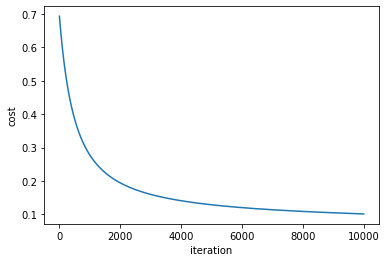

In [19]:
import matplotlib.pyplot as plt

plt.plot(costs)
plt.xlabel('iteration')
plt.ylabel('cost')

## Error Analysis (misclasifications) and accuracy

```python
def evaluate(x, y, freqs, w, b, predict_tweet=predict_tweet, process_tweet=process_tweet, show_misclassifications=False):
    """
    Arguments:
        test_x -- a list of tweets
        test_y -- (m, 1) vector with the corresponding labels for the list of tweets
        freqs -- a dictionary with the frequency of each pair (or tuple)
        theta -- weight vector of dimension (3, 1)
    Returns:
        accuracy -- (# of tweets classified correctly) / (total # of tweets)
    """

    print("evaluate is running")
    # the list for storing predictions
    y_hat = []

    for tweet in x:
        # get the label prediction for the tweet
        y_pred = predict_tweet(tweet, freqs, w, b)

        if y_pred > 0.5:
            # append 1.0 to the list
            y_hat.append(1.0)
        else:
            # append 0 to the list
            y_hat.append(0.0)

    # With the above implementation, y_hat is a list, but test_y is (m,1) array
    # convert both to one-dimensional arrays in order to compare them using the '==' operator
    accuracy = (np.asarray(y_hat) == np.squeeze(y)).sum() / len(x)
    print(accuracy)

    if show_misclassifications == True:
        print("Misclassifications:")
        for i in range(len(y_hat)):
            if np.abs(y[0, i] - (y_hat[i] > 0.5)) > 0:
                print('THE RAW TWEET IS:', x[i])
                print('THE PROCESSED TWEET IS:', process_tweet(x[i]))
                print('%d\t%0.8f\t%s' % (y[0, i], y_hat[i], ' '.join(process_tweet(x[i])).encode('ascii', 'ignore')))

    return accuracy
```

In [13]:
train_accuracy = evaluate(train_x, train_y, freqs, w, b, show_misclassifications=True)

evaluate is running
0.995875
Misclassifications:
THE RAW TWEET IS: Funny how that happened when Phil was here too : )
THE PROCESSED TWEET IS: ['funni', 'happen', 'phil']
1	0.00000000	b'funni happen phil'
THE RAW TWEET IS: Remember that one time I didn't go to flume/kaytranada/alunageorge even though I had tickets? I still want to kms. : ) : )
THE PROCESSED TWEET IS: ['rememb', 'one', 'time', 'go', 'flume', 'kaytranada', 'alunageorg', 'even', 'though', 'ticket', 'still', 'want', 'km']
1	0.00000000	b'rememb one time go flume kaytranada alunageorg even though ticket still want km'
THE RAW TWEET IS: @ellekagaoan @chinmarquez Catch up once in a while :( &gt;:D&lt; @aditriphosphate @ErinMonzon
THE PROCESSED TWEET IS: ['catch', ':(', '>:d']
1	0.00000000	b'catch :( >:d'
THE RAW TWEET IS: @_sarah_mae omg you can't just tell this and don't say more :p can't wait to know !!!! ❤️
THE PROCESSED TWEET IS: ['omg', "can't", 'tell', 'say', ':p', "can't", 'wait', 'know', '❤', '️']
1	0.00000000	b"omg can

In [14]:
test_accuracy = evaluate(test_x, test_y, freqs, w, b, show_misclassifications=True)

evaluate is running
0.996
Misclassifications:
THE RAW TWEET IS: @msarosh Uff Itna Miss karhy thy ap :p
THE PROCESSED TWEET IS: ['uff', 'itna', 'miss', 'karhi', 'thi', 'ap', ':p']
1	0.00000000	b'uff itna miss karhi thi ap :p'
THE RAW TWEET IS: @phenomyoutube u probs had more fun with david than me : (
THE PROCESSED TWEET IS: ['u', 'prob', 'fun', 'david']
0	1.00000000	b'u prob fun david'
THE RAW TWEET IS: pats jay : (
THE PROCESSED TWEET IS: ['pat', 'jay']
0	1.00000000	b'pat jay'
THE RAW TWEET IS: @bae_ts WHATEVER STIL L YOUNG &gt;:-(
THE PROCESSED TWEET IS: ['whatev', 'stil', 'l', 'young', '>:-(']
0	1.00000000	b'whatev stil l young >:-('
THE RAW TWEET IS: my beloved grandmother : ( https://t.co/wt4oXq5xCf
THE PROCESSED TWEET IS: ['belov', 'grandmoth']
0	1.00000000	b'belov grandmoth'
THE RAW TWEET IS: @CHEDA_KHAN Thats life. I get calls from people I havent seen in 20 years and its always favours : (
THE PROCESSED TWEET IS: ['that', 'life', 'get', 'call', 'peopl', 'havent', 'seen', '20',

In [16]:
print('train/test acuracies:', train_accuracy, test_accuracy)

train/test acuracies: 0.995875 0.996
